# Churn Prediction

## Import The Needed Libraries

In [1]:
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
from pandas import to_datetime
import itertools
import warnings
import datetime
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

## Load The Data

In [2]:
raw_data = pd.read_csv('churn raw data.csv', encoding='latin-1')

#print the rows and columns
print(raw_data.shape)

#print the first 5 rows
raw_data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
for column in raw_data:
    unique_vals = np.unique(raw_data[column])
    n_unique = len(unique_vals)
    if n_unique < 12:
        print('The number of values for feature {} :{} -- {}'.format(column, n_unique,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, n_unique))

The number of values for feature RowNumber :10000
The number of values for feature CustomerId :10000
The number of values for feature Surname :2932
The number of values for feature CreditScore :460
The number of values for feature Geography :3 -- ['France' 'Germany' 'Spain']
The number of values for feature Gender :2 -- ['Female' 'Male']
The number of values for feature Age :70
The number of values for feature Tenure :11 -- [ 0  1  2  3  4  5  6  7  8  9 10]
The number of values for feature Balance :6382
The number of values for feature NumOfProducts :4 -- [1 2 3 4]
The number of values for feature HasCrCard :2 -- [0 1]
The number of values for feature IsActiveMember :2 -- [0 1]
The number of values for feature EstimatedSalary :9999
The number of values for feature Exited :2 -- [0 1]


In [4]:
# Checking the nulls
raw_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
raw_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
# Limiting the data
raw_data2 = raw_data[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']]

# Visualize the data using seaborn Pairplots
g = sns.pairplot(raw_data2, hue = 'Exited', diag_kws={'bw': 0.2})

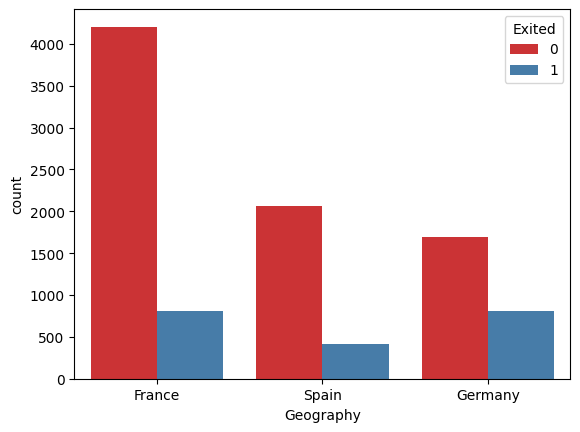

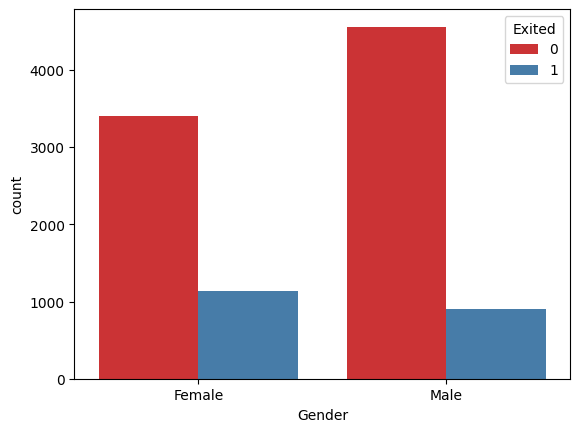

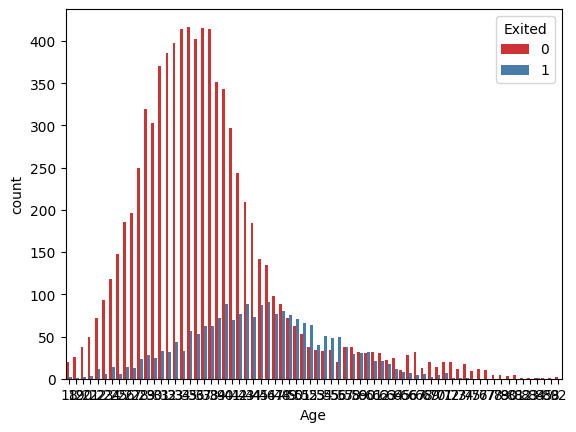

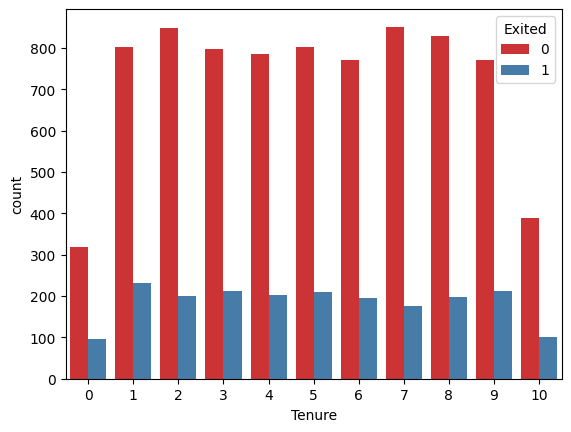

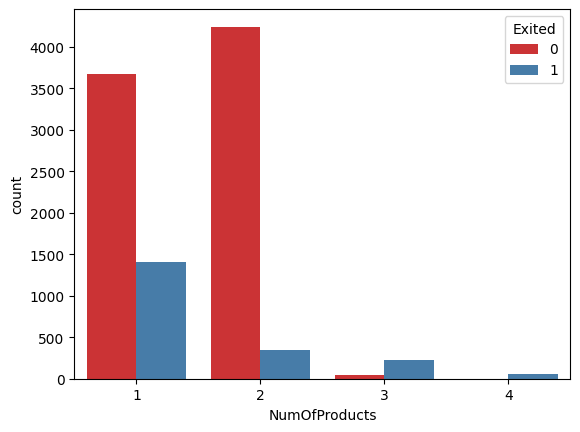

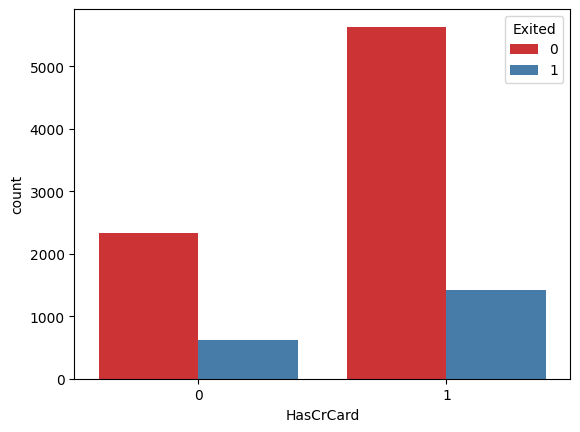

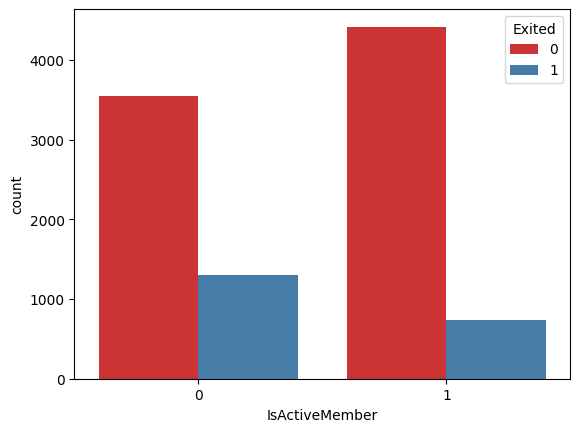

In [7]:
features = ['Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']


for f in features:
    plt.figure()
    ax = sns.countplot(x=f, data=raw_data2, hue = 'Exited', palette="Set1")

In [8]:
raw_data2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# Making categorical variables into numeric representation
new_raw_data = pd.get_dummies(
    raw_data2, 
    columns=['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'],
    dtype=int
)
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,1,0,0,1
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,0,1,1,0
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


In [10]:
new_raw_data['Balance'].max()

250898.09

## Scale and Split the Training and Testing Sets

In [11]:
# Scaling our columns
scale_vars = ['CreditScore','EstimatedSalary','Balance','Age']
scaler = MinMaxScaler()
new_raw_data[scale_vars] = scaler.fit_transform(new_raw_data[scale_vars])
new_raw_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.324324,2,0.000000,1,0.506735,1,1,0,0,1,0,0,1,0,1
1,0.516,0.310811,1,0.334031,1,0.562709,0,0,0,1,1,0,1,0,0,1
2,0.304,0.324324,8,0.636357,3,0.569654,1,1,0,0,1,0,0,1,1,0
3,0.698,0.283784,1,0.000000,2,0.469120,0,1,0,0,1,0,1,0,1,0
4,1.000,0.337838,2,0.500246,1,0.395400,0,0,0,1,1,0,0,1,0,1


In [12]:
X = new_raw_data.drop('Exited', axis=1).values# Input features (attributes)
y = new_raw_data['Exited'].values # Target vector
print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

X shape: (10000, 15)
y shape: (10000,)


## Decision Tree Model

In [13]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=1)

In [14]:
# Calculating FI
for i, column in enumerate(new_raw_data.drop('Exited', axis=1)):
    print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': [dt.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi,fi], ignore_index = True)
    except:
        final_fi = fi
        
        
# Ordering the data
final_fi = final_fi.sort_values('Feature Importance Score', ascending = False).reset_index()            
final_fi

Importance of feature CreditScore:, 0.000
Importance of feature Age:, 0.622
Importance of feature Tenure:, 0.000
Importance of feature Balance:, 0.000
Importance of feature NumOfProducts:, 0.196
Importance of feature EstimatedSalary:, 0.000
Importance of feature Geography_France:, 0.000
Importance of feature Geography_Germany:, 0.000
Importance of feature Geography_Spain:, 0.000
Importance of feature Gender_Female:, 0.000
Importance of feature Gender_Male:, 0.000
Importance of feature HasCrCard_0:, 0.000
Importance of feature HasCrCard_1:, 0.000
Importance of feature IsActiveMember_0:, 0.000
Importance of feature IsActiveMember_1:, 0.182


,index,Variable,Feature Importance Score
0,1,Age,0.622346
1,4,NumOfProducts,0.195552
2,14,IsActiveMember_1,0.182102
3,0,CreditScore,0.000000
4,2,Tenure,0.000000
5,3,Balance,0.000000
6,5,EstimatedSalary,0.000000
7,6,Geography_France,0.000000
8,7,Geography_Germany,0.000000
9,8,Geography_Spain,0.000000


In [15]:
# Accuracy on Train
print("Training Accuracy is: ", dt.score(X_train, y_train))

# Accuracy on Train
print("Testing Accuracy is: ", dt.score(X_test, y_test))

Training Accuracy is:  0.8213333333333334
Testing Accuracy is:  0.822


### Confusion Matrix function

In [16]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Predictions for Decision Tree

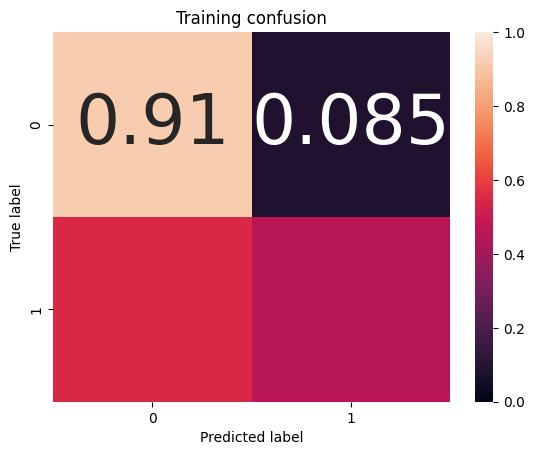

In [17]:
y_pred = dt.predict(X_train)

# Plotting Confusion Matrix
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=dt.classes_, title='Training confusion')

In [18]:
y_pred = dt.predict(X_train)
y_pred
confusion_matrix(y_train, y_pred)

array([[6558,  611],
       [ 997,  834]])

In [19]:
# Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print ("The True Positive rate / Recall per class is: ",TPR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print ("The Precision per class is: ",PPV)

# False positive rate or False alarm rate
FPR = FP/(FP+TN)
print ("The False Alarm rate per class is: ",FPR)

# False negative rate or Miss Rate
FNR = FN/(TP+FN)
print ("The Miss Rate rate per class is: ",FNR)

# Classification error
CER = (FP+FN)/(TP+FP+FN+TN)
print ("The Classification error of each class is", CER)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print ("The Accuracy of each class is", ACC)
print("")

##Total averages :
print ("The average Recall is: ",TPR.sum()/2)
print ("The average Precision is: ",PPV.sum()/2)
print ("The average False Alarm is: ",FPR.sum()/2)
print ("The average Miss Rate rate is: ",FNR.sum()/2)
print ("The average Classification error is", CER.sum()/2)
print ("The average Accuracy is", ACC.sum()/2)

The True Positive rate / Recall per class is:  [0.91477193 0.4554888 ]
The Precision per class is:  [0.86803441 0.57716263]
The False Alarm rate per class is:  [0.5445112  0.08522807]
The Miss Rate rate per class is:  [0.08522807 0.5445112 ]
The Classification error of each class is [0.17866667 0.17866667]
The Accuracy of each class is [0.82133333 0.82133333]

The average Recall is:  0.685130369325603
The average Precision is:  0.7225985220264771
The average False Alarm is:  0.31486963067439694
The average Miss Rate rate is:  0.31486963067439694
The average Classification error is 0.17866666666666667
The average Accuracy is 0.8213333333333334


## Random Forest Model

Training Accuracy is:  1.0
Testing Accuracy is:  0.864


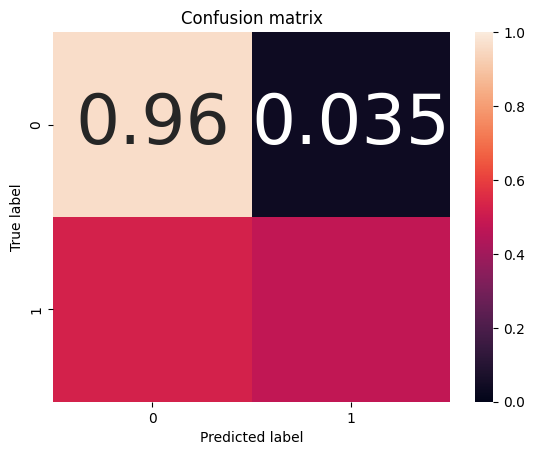

In [20]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
rf.fit(X_train, y_train)
prediction_test = rf.predict(X=X_test)

# Accuracy on Test
print("Training Accuracy is: ", rf.score(X_train, y_train))
# Accuracy on Train
print("Testing Accuracy is: ", rf.score(X_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, prediction_test)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

Classification accuracy on test set with max features = 1 and max_depth = None: 0.861
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.794
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.797
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.802
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.865
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.799
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.811
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.829
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.850
Classification accuracy on test set with max features = log2 and max_depth = None: 0.865
Classification accuracy on test set with max features = log2

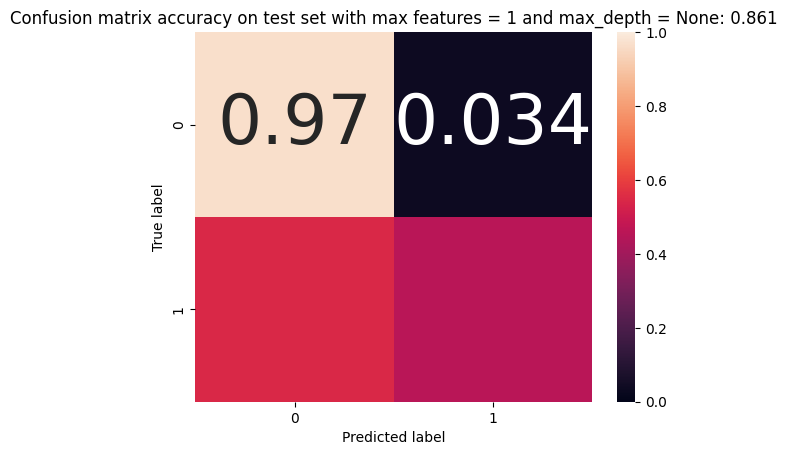

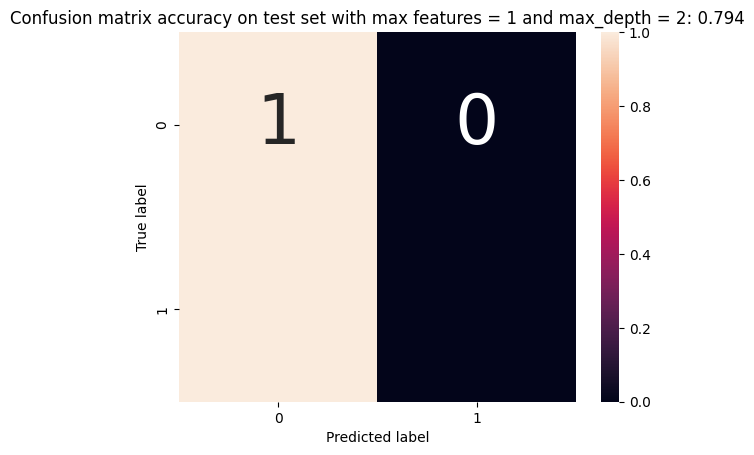

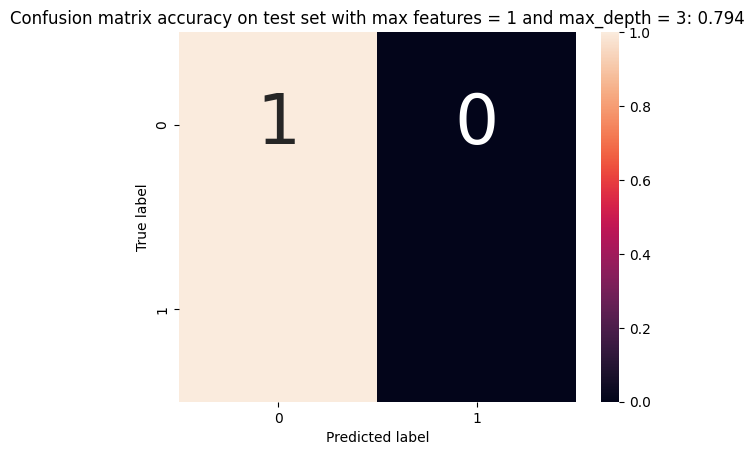

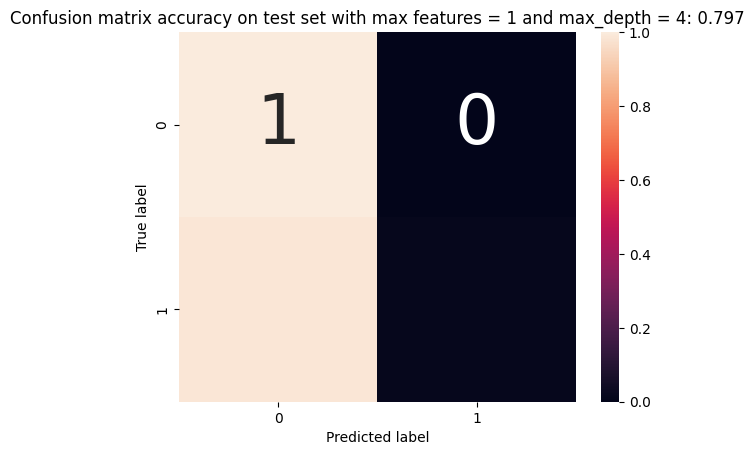

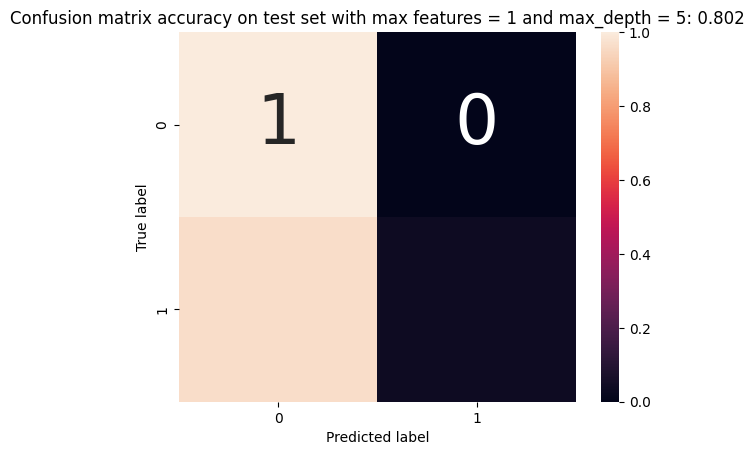

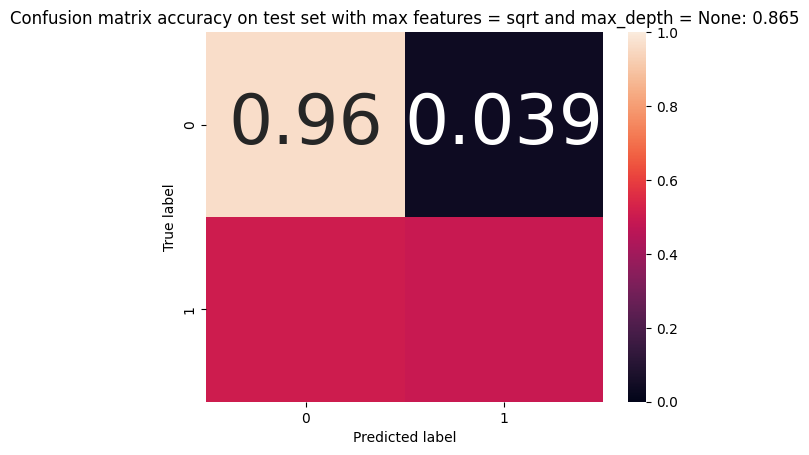

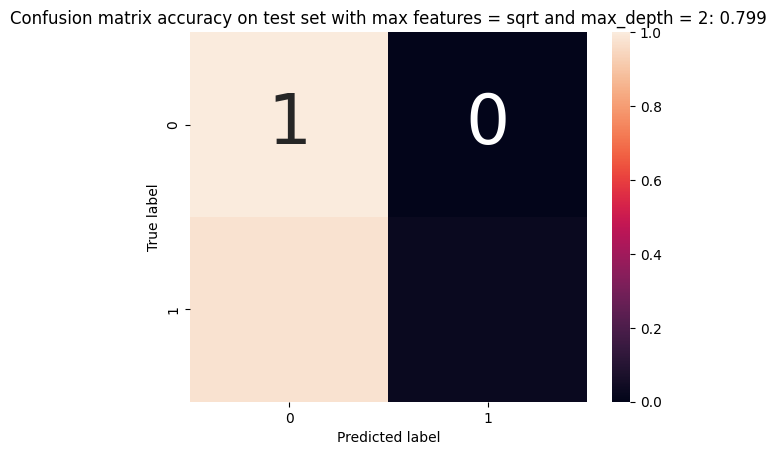

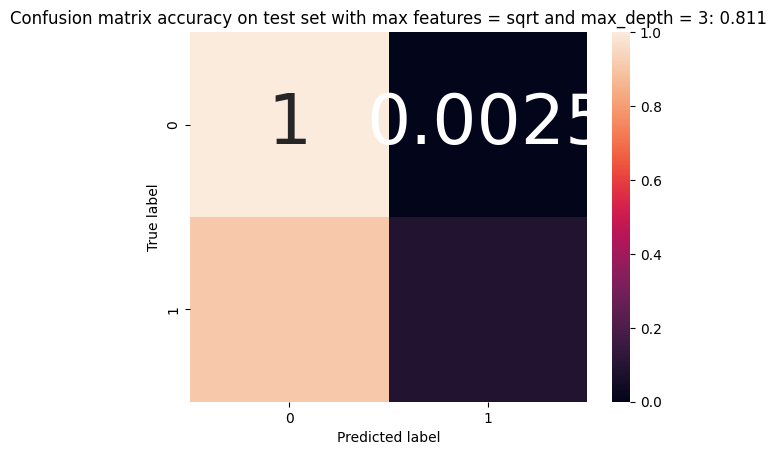

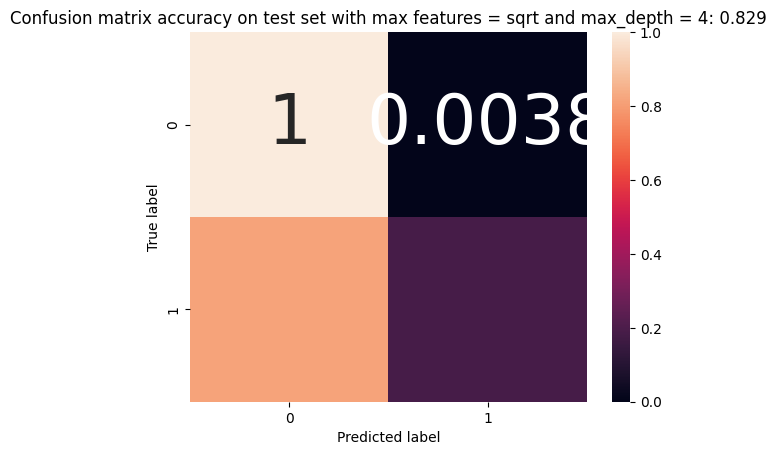

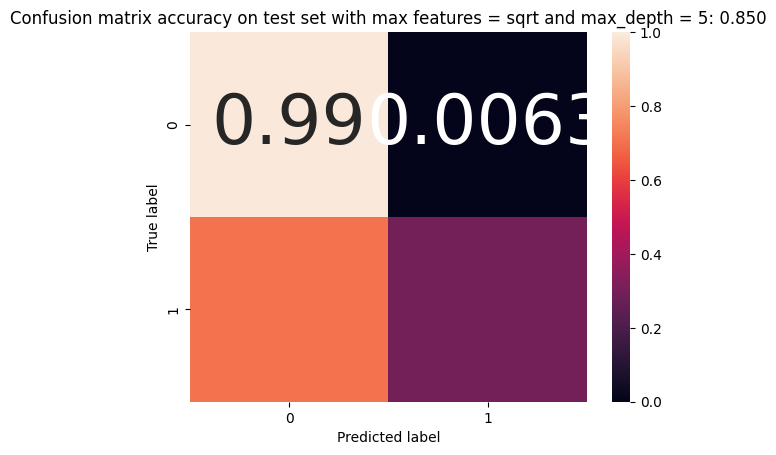

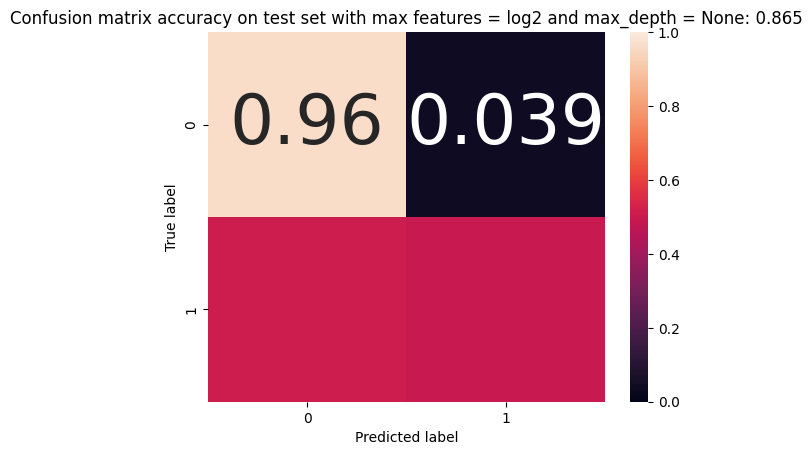

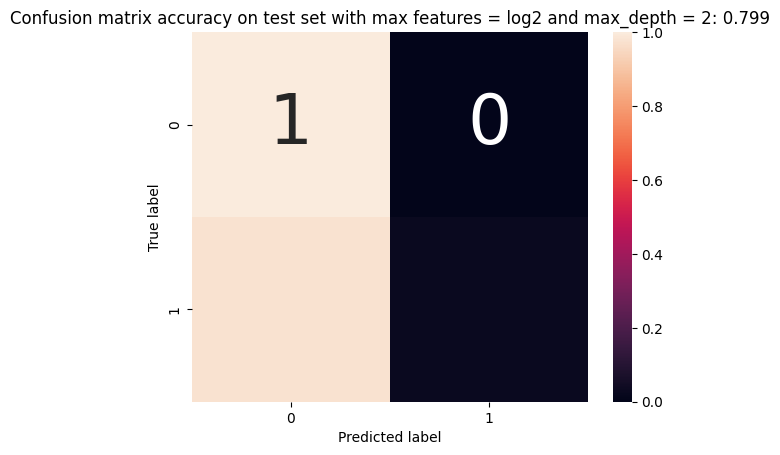

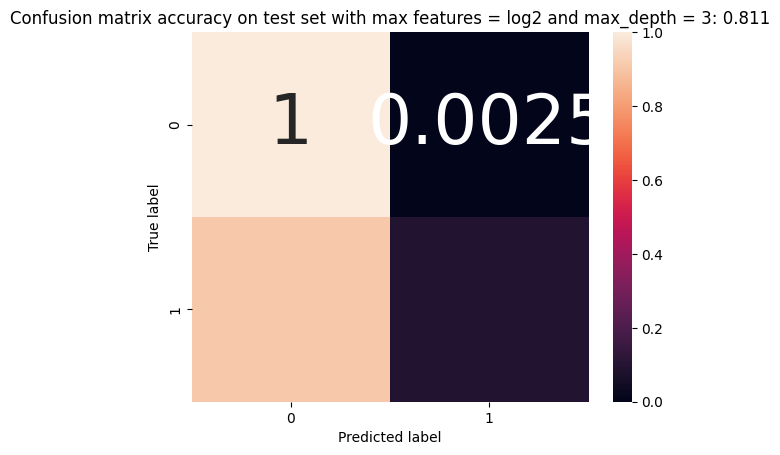

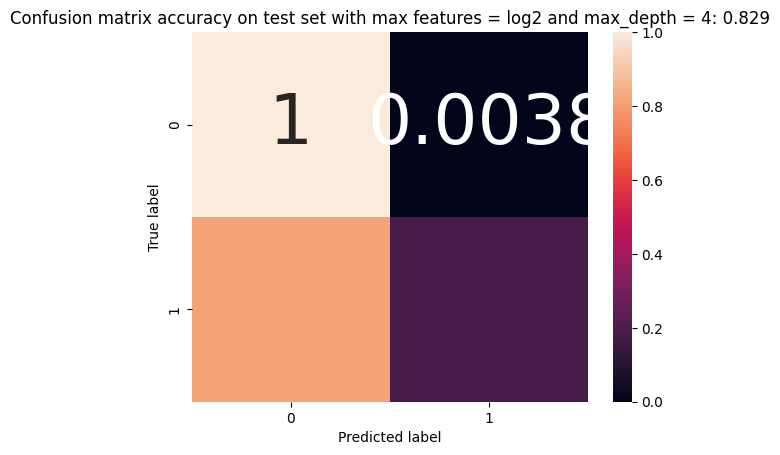

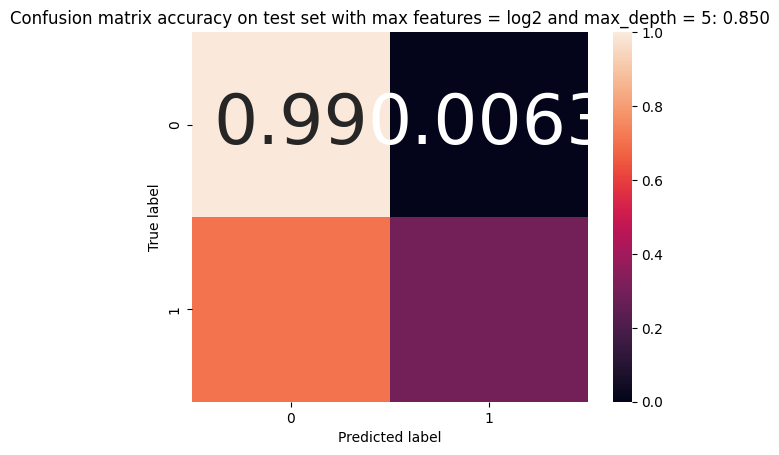

In [21]:
from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2, 3, 4, 5]
for f, d in product(max_features, max_depths): # with product we can iterate through all possible combinations
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rf.fit(X_train, y_train)
    prediction_test = rf.predict(X=X_test)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))
    cm = confusion_matrix(y_test, prediction_test)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=rf.classes_,
    title='Confusion matrix accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(y_test,prediction_test)))

## XGBoost Model

In [22]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

classifier=xgboost.XGBClassifier(tree_method='hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)

# fitting it
clf.fit(X,y)

# best parameters
clf.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=0.869 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=0.866 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=0.857 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=0.865 total time=   0.0s
[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=0.859 total time=   0.0s
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.3, max_depth=8, min_child_weight=3;, score=0.842 total time=   0.0s
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.3, max_depth=8, min_child_weight=3;, score=0.853 total time=   0.0s
[CV 3/5] END colsample_bytree=

{'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [23]:
clf.best_params_

{'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [24]:
clf.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

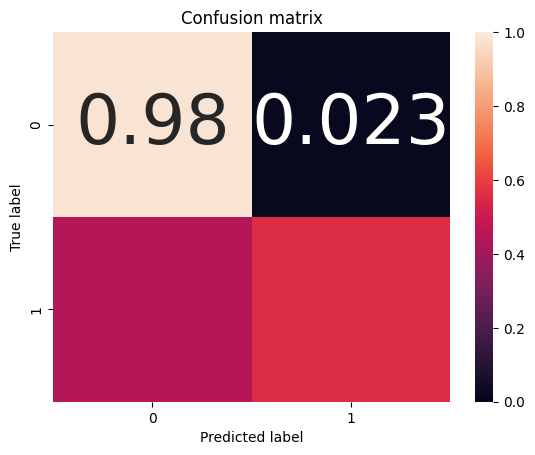

In [25]:
final_model = xgboost.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None)

# fitting it
final_model.fit(X,y)

pred_xgboost = final_model.predict(X)

# Confusion Matrix
cm = confusion_matrix(y, pred_xgboost)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=rf.classes_)

## Final Model Predictions

In [28]:
# Loading from CSV
unseen_data = pd.read_csv('new unseen data.csv', encoding='latin-1')
unseen_data2 = pd.read_csv('new unseen data.csv', encoding='latin-1')

In [29]:
unseen_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Preprocessing Steps for the unseen data

In [30]:
# Limiting the data
unseen_data = unseen_data[['CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']]

# dummy variables
unseen_data = pd.get_dummies(unseen_data, columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], dtype=int)

#scaling
scale_vars = ['CreditScore','EstimatedSalary','Balance','Age']
unseen_data[scale_vars] = scaler.fit_transform(unseen_data[scale_vars])


unseen_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0,HasCrCard_1,IsActiveMember_0,IsActiveMember_1
0,0.538,0.342857,2,0.000000,1,0.507077,1,0,0,1,0,0,1,0,1
1,0.516,0.328571,1,0.334031,1,0.563089,0,0,1,1,0,1,0,0,1
2,0.304,0.342857,8,0.636357,3,0.570039,1,0,0,1,0,0,1,1,0
3,0.698,0.300000,1,0.000000,2,0.469437,1,0,0,1,0,1,0,1,0
4,1.000,0.357143,2,0.500246,1,0.395667,0,0,1,1,0,0,1,0,1


In [31]:
pred_xgboost = final_model.predict(unseen_data.values)
pred_prob_xgboost = final_model.predict_proba(unseen_data.values)

pred_xgboost

array([0, 0, 1, ..., 0, 0, 0])

In [32]:
# probabilities
pred_prob_xgboost

array([[0.6540806 , 0.3459194 ],
       [0.7670698 , 0.23293021],
       [0.03303134, 0.96696866],
       ...,
       [0.89070433, 0.10929565],
       [0.8461442 , 0.1538558 ],
       [0.88729674, 0.11270324]], dtype=float32)

In [33]:
# function to select second column for probabilities
def column(matrix, i):
    return [row[i] for row in matrix]

column(pred_prob_xgboost, 1)

[0.3459194,
 0.23293021,
 0.96696866,
 0.07676778,
 0.088869415,
 0.23802975,
 0.036918603,
 0.96761954,
 0.049392346,
 0.036560252,
 0.027866457,
 0.018089356,
 0.041277677,
 0.021821085,
 0.025676928,
 0.14585745,
 0.9523857,
 0.024869675,
 0.43619522,
 0.029844554,
 0.023848407,
 0.028776644,
 0.34734228,
 0.04947478,
 0.20169185,
 0.0069794958,
 0.2297907,
 0.05169348,
 0.45474562,
 0.24398234,
 0.8280308,
 0.06797958,
 0.24801968,
 0.048111532,
 0.023060242,
 0.68647885,
 0.041763965,
 0.028468233,
 0.130185,
 0.070971325,
 0.22285493,
 0.7657518,
 0.25876665,
 0.6229806,
 0.27982557,
 0.107115485,
 0.30815944,
 0.49884692,
 0.31146482,
 0.06119043,
 0.14730422,
 0.1356667,
 0.047521718,
 0.47098583,
 0.75541925,
 0.16858177,
 0.3396641,
 0.10861925,
 0.71475106,
 0.48088273,
 0.21420199,
 0.048934914,
 0.091592066,
 0.1130186,
 0.15749674,
 0.03253018,
 0.23665795,
 0.075836755,
 0.040202875,
 0.07759325,
 0.9933013,
 0.12733409,
 0.0978048,
 0.037828982,
 0.01929257,
 0.12539436

In [35]:
output = unseen_data2.copy()
output['Predictions - Churn or Not'] = pred_xgboost
output['Predictions - Probability to Churn'] = column(pred_prob_xgboost, 1)
output['Predictions - Churn or Not Desc'] = 'Empty'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 0] = 'Retention'
output['Predictions - Churn or Not Desc'][output['Predictions - Churn or Not'] == 1] = 'Churn'
output.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Predictions - Churn or Not,Predictions - Probability to Churn,Predictions - Churn or Not Desc
0,1,15634638,AP Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,0.345919,Retention
1,2,15647347,AP Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0,0.232930,Retention
2,3,15619340,AP Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,0.966969,Churn
3,4,15701390,AP Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,0.076768,Retention
4,5,15737924,AP Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,0.088869,Retention


In [36]:
output.to_excel('Churn Predictions.xlsx')